In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
     

In [11]:
torch.cuda.is_available()
device = 'cuda'

In [12]:
torch.cuda.is_available()

True

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations
     

In [3]:
import matplotlib.pyplot as plt

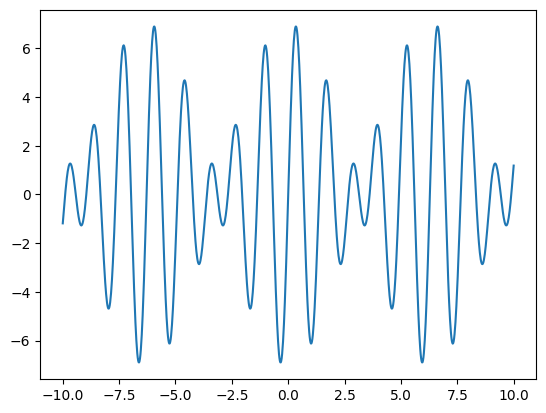

In [4]:
x_full = np.linspace(-10,10,1000)
y_full = 3*np.sin(4*x_full)+4*np.sin(5*x_full)
plt.plot(x_full,y_full)

In [5]:
torch.manual_seed(20)

In [6]:
X_train = np.linspace(-5,5,500)
y_train = 3*np.sin(4*X_train)+4*np.sin(5*X_train)

In [23]:
X_train_updated = []
for x in X_train:
  temp = []
  for k in np.linspace(0.1,10,50):
    temp.append(np.sin(k*x))
  X_train_updated.append(temp)

In [24]:
X_train_updated = np.array(X_train_updated)

In [39]:
X_test_full = np.linspace(-10,10,1000)
X_test_updated = []
for x in X_test_full:
  temp = []
  for k in np.linspace(0.1,10,50):
    temp.append(np.sin(k*x))
  X_test_updated.append(temp)

In [41]:
np.array(X_test_updated).shape

(1000, 50)

In [25]:

X_test_updated = []
X_train_updated.shape

(500, 50)

In [48]:
def siren_fit (first_omega_0, hidden_omega_0, num_epochs, display = False, lr =  1e-4):
  siren_model = Siren(in_features=50, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True, first_omega_0 = first_omega_0, hidden_omega_0 = hidden_omega_0).to(device) # omega = 30 by default
  criterion = nn.MSELoss()
  optimizer = optim.Adam(siren_model.parameters(), lr=lr) 
  num_epochs = num_epochs
  X = X_train_updated
  y = y_train
  X_tensor = torch.from_numpy(X.astype('float32')).to(device)
  y_tensor = torch.from_numpy(y.astype('float32')).to(device)
  for e in range(num_epochs+1):
    y_pred_train = siren_model(X_tensor)[0].squeeze()
    loss = criterion(y_pred_train, y_tensor) # loss is a tensor which stores the current value of train loss


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_now = loss.item()
    #if (e%100==0):
      #print(f"iteration {e}/{num_epochs} loss is {loss_now}")
  X_test_tensor = torch.from_numpy(np.array(X_test_updated).astype('float32')).to(device)
  y_preds = siren_model(X_test_tensor)[0].squeeze()
  """if (display == True):
    plt.plot(x_full, y_full, label = "ground_truth")
    plt.plot(X_test_full,y_preds.detach().numpy(), label = "predicted")
    plt.legend()
    plt.show()"""
  return X_test_tensor, y_preds.cpu().detach().numpy()

In [10]:
np.array(X_train_updated).shape

(500, 50)

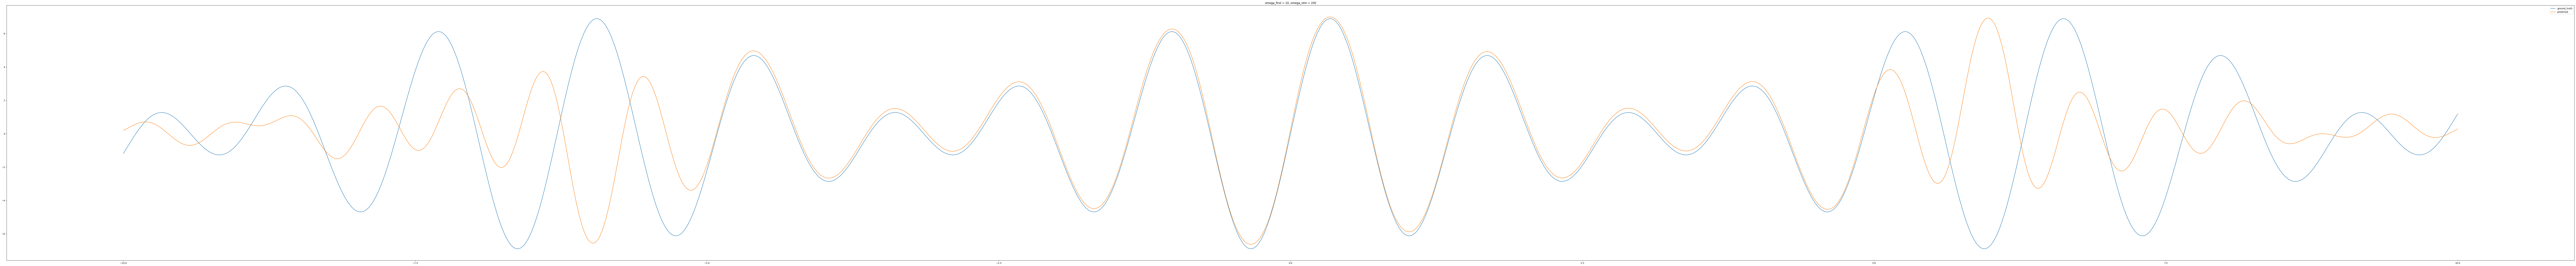

In [59]:
x,y = siren_fit(0.0001, 10, 10000, 1e-4)
plt.figure(figsize=(200, 20))
plt.plot(x_full, y_full, label = "ground_truth")
plt.plot(x_full,y, label = 'predicted')
plt.title(f'omega_first = {10}, omega_rem = {200}')
plt.legend()
plt.show()

In [50]:
y

array([ 1.16064179e+00,  1.56369328e+00,  1.91050911e+00,  2.03246474e+00,
        1.97607350e+00,  1.84885454e+00,  1.66604471e+00,  1.43202400e+00,
        1.25289631e+00,  1.20964205e+00,  1.27768159e+00,  1.40444779e+00,
        1.54253566e+00,  1.61265206e+00,  1.55662727e+00,  1.45831835e+00,
        1.44000971e+00,  1.51179206e+00,  1.66129065e+00,  1.88710809e+00,
        2.11056089e+00,  2.23323226e+00,  2.20604730e+00,  2.01691866e+00,
        1.74610353e+00,  1.53708696e+00,  1.46168411e+00,  1.53831410e+00,
        1.74792588e+00,  1.98525906e+00,  2.13749528e+00,  2.17002702e+00,
        2.04515839e+00,  1.80008936e+00,  1.59579253e+00,  1.49866295e+00,
        1.44499266e+00,  1.34024727e+00,  1.17955005e+00,  9.66367304e-01,
        7.54771948e-01,  6.76894188e-01,  6.67135537e-01,  6.81747854e-01,
        7.59452522e-01,  8.82765174e-01,  9.52058971e-01,  9.84221458e-01,
        1.07289875e+00,  1.20935869e+00,  1.34586179e+00,  1.53275657e+00,
        1.56790471e+00,  

In [36]:
for obj in torch.cuda.all_tensors():
    # Print tensor information
    print("Tensor:", obj)
    print("Location:", "GPU" if obj.is_cuda else "CPU")
    print("Device Index:", obj.get_device() if obj.is_cuda else None)
    print()

AttributeError: ignored